In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib as mpl
import time
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from PIL import Image
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

try:
    import cust_f
except:
    pass
# to perform multiprocessing using a customized function (not necessary for Linux)

tot_run_time_start = time.time()

# 데이터 가져오기

In [95]:
with open("../btc_usd_1d.pkl","rb") as fr:
    data = pickle.load(fr)
print(data)

                   o         h         l         c             v
ot                                                              
2014-11-29    376.42    386.60    372.25    376.72  2.746157e+06
2014-11-30    376.57    381.99    373.32    373.34  1.145567e+06
2014-12-01    376.40    382.31    373.03    378.39  2.520662e+06
2014-12-02    378.39    382.86    375.23    379.25  2.593576e+06
2014-12-03    379.25    383.00    374.23    376.67  2.998358e+06
...              ...       ...       ...       ...           ...
2022-01-20  41733.21  43518.69  40554.14  40736.05  2.425153e+03
2022-01-21  40654.72  41115.58  35423.00  36495.46  6.201046e+03
2022-01-22  36447.37  36825.98  34000.00  35091.11  4.510372e+03
2022-01-23  35084.79  36574.47  34624.59  36293.62  2.533704e+03
2022-01-24  36262.21  36276.86  35917.44  35917.44  3.775357e+01

[2614 rows x 5 columns]


In [96]:
data

,o,h,l,c,v
ot,,,,,
2014-11-29,376.42,386.60,372.25,376.72,2.746157e+06
2014-11-30,376.57,381.99,373.32,373.34,1.145567e+06
2014-12-01,376.40,382.31,373.03,378.39,2.520662e+06
2014-12-02,378.39,382.86,375.23,379.25,2.593576e+06
2014-12-03,379.25,383.00,374.23,376.67,2.998358e+06
...,...,...,...,...,...
2022-01-20,41733.21,43518.69,40554.14,40736.05,2.425153e+03
2022-01-21,40654.72,41115.58,35423.00,36495.46,6.201046e+03
2022-01-22,36447.37,36825.98,34000.00,35091.11,4.510372e+03


# 1. 간단한 모형 테스트

## 윈도우 크기 및 배치 사이즈

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
WINDOW_SIZE=50
BATCH_SIZE=32

## 데이터 전처리

In [ ]:
data.columns = ['Open','High','Low','Close','Volume']

In [ ]:
# MinMax 스케일링


scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(data[scale_cols])
scaled

In [ ]:
# 전처리 완료된 최종 데이터 프레임 df 생성

df = pd.DataFrame(scaled, columns=scale_cols)

## 데이터 split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [ ]:
x_train.shape, y_train.shape

In [ ]:
x_test.shape, y_test.shape

In [ ]:
x_train

In [ ]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

## Modeling

In [ ]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [ ]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

## 결과

In [ ]:
model.load_weights(filename)

In [ ]:
pred = model.predict(test_data)

In [ ]:
pred.shape

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [ ]:
model.summary()

# 2. 다중 채널 비트코인 가격 예측 (many to many)

## 데이터 전처리

In [4]:
data.columns = ['Open','High','Low','Close','Volume']

In [5]:
# MinMax 스케일링


scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(data[scale_cols])
scaled

array([[3.18199066e-03, 2.52605283e-03, 3.32614195e-03, 3.18589848e-03,
        3.55568085e-03],
       [3.18421666e-03, 2.45903451e-03, 3.34233013e-03, 3.13574788e-03,
        1.48326158e-03],
       [3.18169386e-03, 2.46368654e-03, 3.33794268e-03, 3.21067703e-03,
        3.26371389e-03],
       ...,
       [5.38474529e-01, 5.32267068e-01, 5.12085159e-01, 5.18259121e-01,
        5.83995879e-06],
       [5.18253856e-01, 5.28610717e-01, 5.21534670e-01, 5.36101310e-01,
        3.28059996e-06],
       [5.35726757e-01, 5.24284183e-01, 5.41094382e-01, 5.30519756e-01,
        4.88827305e-08]])

In [6]:
# 전처리 완료된 최종 데이터 프레임 df 생성

df = pd.DataFrame(scaled, columns=scale_cols)

In [7]:
# data를 numpy형태로 전환

seq=df.to_numpy()

## 윈도우 크기와 수평선 크기

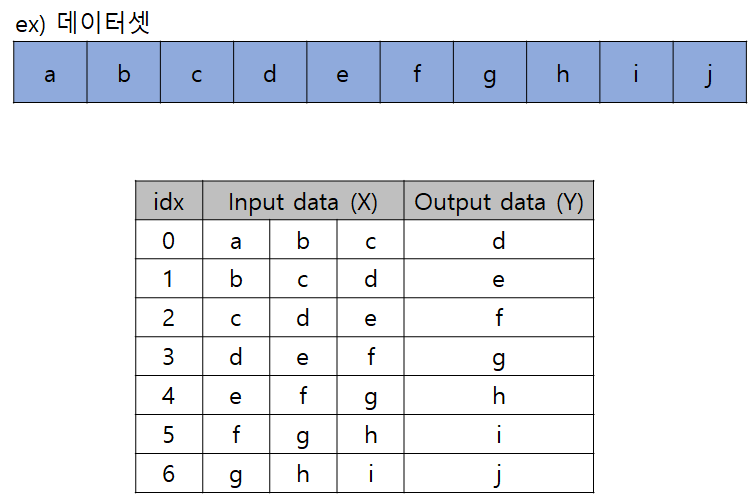

In [8]:
def seq2dataset(seq,window,horizon):
    X=[]; Y=[]
    for i in range(len(seq)-(window+horizon)+1):
        x=seq[i:(i+window)]
        y=(seq[i+window+horizon-1])
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

In [9]:
# 윈도우 w와 수평선 h

w = 100   # 윈도우는 이전 요소 몇 개를 볼 것인지
h = 10    # 수평선은 얼마나 먼 미래를 예측할 것인지

In [10]:
X, Y = seq2dataset(seq, w, h)

In [11]:
print(X.shape, Y.shape)

(2505, 100, 5) (2505, 5)


In [28]:
print(X[0], Y[0])

[[3.18199066e-03 2.52605283e-03 3.32614195e-03 3.18589848e-03
  3.55568085e-03]
 [3.18421666e-03 2.45903451e-03 3.34233013e-03 3.13574788e-03
  1.48326158e-03]
 [3.18169386e-03 2.46368654e-03 3.33794268e-03 3.21067703e-03
  3.26371389e-03]
 [3.21122544e-03 2.47168222e-03 3.37122679e-03 3.22343724e-03
  3.35812190e-03]
 [3.22398783e-03 2.47371748e-03 3.35609765e-03 3.18515661e-03
  3.88222656e-03]
 [3.18570066e-03 2.41542172e-03 3.14096125e-03 3.01497099e-03
  4.27006434e-03]
 [3.01548597e-03 2.39943036e-03 3.20117523e-03 3.15963619e-03
  4.31391354e-03]
 [3.16017588e-03 2.38634652e-03 3.31192055e-03 3.16141668e-03
  1.11577864e-03]
 [3.16195668e-03 2.39376070e-03 3.33990947e-03 3.18812410e-03
  1.18306458e-03]
 [3.18866866e-03 2.39303382e-03 3.21040401e-03 3.00621689e-03
  4.73274504e-03]
 [3.00673038e-03 2.21901878e-03 2.89828980e-03 2.79671202e-03
  9.55092856e-03]
 [2.79718972e-03 2.04834740e-03 2.94761081e-03 2.76169562e-03
  2.98361775e-03]
 [2.76216734e-03 2.20375431e-03 2.835201

## 데이터셋 split

In [13]:
split=int(len(X)*0.7)

In [14]:
x_train=X[0:split]
y_train=Y[0:split]
x_test=X[split:]
y_test=Y[split:]

## Modeling

In [108]:
model = Sequential()
model.add(LSTM(units=16,activation='tanh',input_shape=x_train[0].shape))
model.add(Dense(16, activation="relu"))
model.add(Dense(5))

In [109]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [110]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [111]:
hist=model.fit(x_train,y_train,epochs=200,batch_size=16,validation_data=(x_test,y_test),callbacks=[checkpoint, earlystopping], verbose=1)

Epoch 1/200
109/110 [============================>.] - ETA: 0s - loss: 8.7165e-04 - mse: 0.0017
Epoch 1: val_loss improved from inf to 0.03985, saving model to tmp\ckeckpointer.ckpt
110/110 [==============================] - 4s 25ms/step - loss: 8.7021e-04 - mse: 0.0017 - val_loss: 0.0398 - val_mse: 0.0797
Epoch 2/200
108/110 [============================>.] - ETA: 0s - loss: 3.4898e-04 - mse: 6.9795e-04
Epoch 2: val_loss improved from 0.03985 to 0.03949, saving model to tmp\ckeckpointer.ckpt
110/110 [==============================] - 3s 23ms/step - loss: 3.4649e-04 - mse: 6.9299e-04 - val_loss: 0.0395 - val_mse: 0.0790
Epoch 3/200
110/110 [==============================] - ETA: 0s - loss: 2.9525e-04 - mse: 5.9049e-04
Epoch 3: val_loss improved from 0.03949 to 0.03921, saving model to tmp\ckeckpointer.ckpt
110/110 [==============================] - 3s 24ms/step - loss: 2.9525e-04 - mse: 5.9049e-04 - val_loss: 0.0392 - val_mse: 0.0784
Epoch 4/200
108/110 [============================>.]

## 모델 평가

In [112]:
ev=model.evaluate(x_test, y_test, verbose=1)

24/24 [==============================] - 0s 7ms/step - loss: 0.0339 - mse: 0.0678   


In [113]:
print("손실 함수:", ev[0], "MSE", ev[1])

손실 함수: 0.03391161933541298 MSE 0.06782323867082596


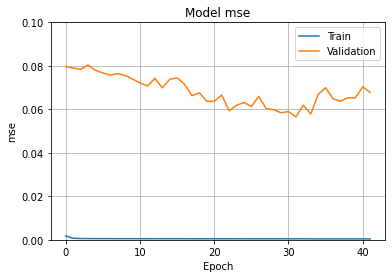

In [123]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('Model mse')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.ylim([0,0.1])
plt.legend(['Train','Validation'], loc='best')
plt.grid()
plt.show()

In [124]:
pred = model.predict(x_test)

In [125]:
pred.shape

(752, 5)

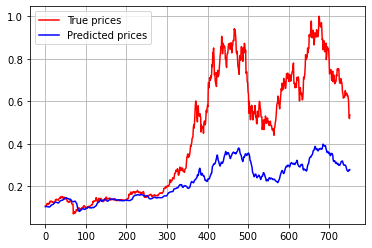

In [126]:
#'Open'

x_range=range(len(y_test))
plt.plot(x_range,y_test[x_range][:,0], color='red')
plt.plot(x_range,pred[x_range][:,0], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

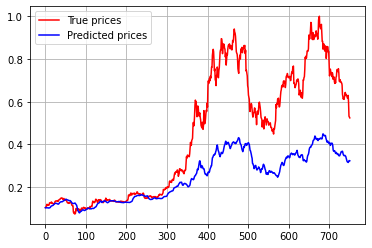

In [127]:
#'High

x_range=range(len(y_test))
plt.plot(x_range,y_test[x_range][:,1], color='red')
plt.plot(x_range,pred[x_range][:,1], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

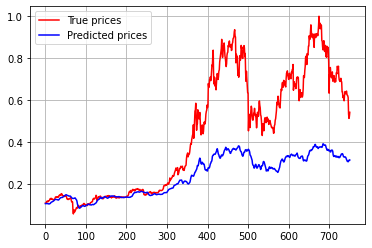

In [128]:
#'Low'

x_range=range(len(y_test))
plt.plot(x_range,y_test[x_range][:,2], color='red')
plt.plot(x_range,pred[x_range][:,2], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

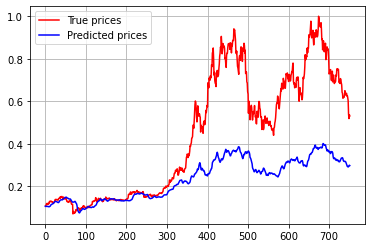

In [129]:
#'Close'

x_range=range(len(y_test))
plt.plot(x_range,y_test[x_range][:,3], color='red')
plt.plot(x_range,pred[x_range][:,3], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

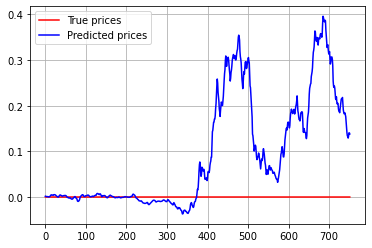

In [130]:
#'Volume'

x_range=range(len(y_test))
plt.plot(x_range,y_test[x_range][:,4], color='red')
plt.plot(x_range,pred[x_range][:,4], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

In [131]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 16)                1408      
                                                                 
 dense_8 (Dense)             (None, 16)                272       
                                                                 
 dense_9 (Dense)             (None, 5)                 85        
                                                                 
Total params: 1,765
Trainable params: 1,765
Non-trainable params: 0
_________________________________________________________________


# 3. 다중 채널 비트코인 가격 예측 (many to one)

## 데이터 전처리

In [97]:
data.columns = ['Open','High','Low','Close','Volume']

In [98]:
# MinMax 스케일링


scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(data[scale_cols])
scaled

array([[3.18199066e-03, 2.52605283e-03, 3.32614195e-03, 3.18589848e-03,
        3.55568085e-03],
       [3.18421666e-03, 2.45903451e-03, 3.34233013e-03, 3.13574788e-03,
        1.48326158e-03],
       [3.18169386e-03, 2.46368654e-03, 3.33794268e-03, 3.21067703e-03,
        3.26371389e-03],
       ...,
       [5.38474529e-01, 5.32267068e-01, 5.12085159e-01, 5.18259121e-01,
        5.83995879e-06],
       [5.18253856e-01, 5.28610717e-01, 5.21534670e-01, 5.36101310e-01,
        3.28059996e-06],
       [5.35726757e-01, 5.24284183e-01, 5.41094382e-01, 5.30519756e-01,
        4.88827305e-08]])

In [99]:
# 전처리 완료된 최종 데이터 프레임 df 생성

df = pd.DataFrame(scaled, columns=scale_cols)

In [100]:
# data를 numpy형태로 전환

seq=df.to_numpy()

## 윈도우 크기와 수평선 크기

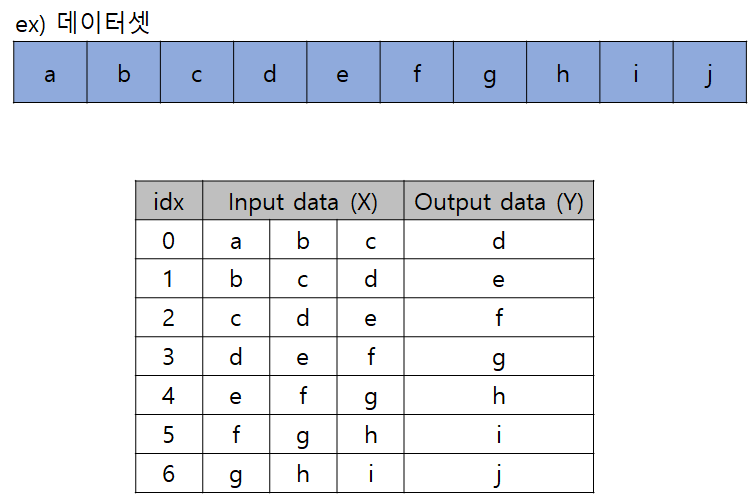

In [101]:
def seq2dataset(seq,window,horizon):
    X=[]; Y=[]
    for i in range(len(seq)-(window+horizon)+1):
        x=seq[i:(i+window)]
        y=(seq[i+window+horizon-1])   # Close(종가)만 y값으로 할당
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

In [102]:
# 윈도우 w와 수평선 h

w = 3   # 윈도우는 이전 요소 몇 개를 볼 것인지
h = 1    # 수평선은 얼마나 먼 미래를 예측할 것인지

In [103]:
X, Y = seq2dataset(seq, w, h)

In [104]:
print(X.shape, Y.shape)

(2611, 3, 5) (2611, 5)


In [35]:
print(X[0], Y[0])

[[0.00318199 0.00252605 0.00332614 0.0031859  0.00355568]
 [0.00318422 0.00245903 0.00334233 0.00313575 0.00148326]
 [0.00318169 0.00246369 0.00333794 0.00321068 0.00326371]] 0.0032234372449812306


## 데이터셋 split

In [36]:
split=int(len(X)*0.7)

In [132]:
x_train=X[0:split]
y_train=Y[0:split]
x_test=X[split:]
y_test=Y[split:]

## Modeling

In [133]:
model = Sequential()
model.add(LSTM(units=16,activation='tanh',input_shape=x_train[0].shape))
model.add(Dense(16, activation="relu"))
model.add(Dense(1))

In [134]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [135]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [138]:
hist=model.fit(x_train,y_train[:,3],epochs=200,batch_size=16,validation_data=(x_test,y_test[:,3]),callbacks=[checkpoint, earlystopping], verbose=1)   
# y_train과 y_test에서 [:,3]로 인덱싱하는 이유는, 종가만을 y_val로 추출하기 위해서임
# x_train 데이터셋 구성 자체가, 한 단위씩(ex 1일, 1시간, 1분) 밀리면서 구성된 데이터셋으로, for문을 돌려가며 예측할 필요 없음

Epoch 1/200
102/115 [=========================>....] - ETA: 0s - loss: 1.4024e-05 - mse: 2.8048e-05
Epoch 1: val_loss did not improve from 0.00761
115/115 [==============================] - 1s 6ms/step - loss: 1.5471e-05 - mse: 3.0943e-05 - val_loss: 0.0095 - val_mse: 0.0191
Epoch 2/200
103/115 [=========================>....] - ETA: 0s - loss: 1.7151e-05 - mse: 3.4302e-05
Epoch 2: val_loss did not improve from 0.00761
115/115 [==============================] - 0s 3ms/step - loss: 1.6565e-05 - mse: 3.3130e-05 - val_loss: 0.0091 - val_mse: 0.0181
Epoch 3/200
103/115 [=========================>....] - ETA: 0s - loss: 1.6194e-05 - mse: 3.2387e-05
Epoch 3: val_loss did not improve from 0.00761
115/115 [==============================] - 0s 3ms/step - loss: 1.6013e-05 - mse: 3.2025e-05 - val_loss: 0.0091 - val_mse: 0.0182
Epoch 4/200
104/115 [==========================>...] - ETA: 0s - loss: 1.5659e-05 - mse: 3.1317e-05
Epoch 4: val_loss did not improve from 0.00761
115/115 [================

# 4. 수익률 확인 (인열님 이미지는 여기 수익률 확인 부분에 있는 것들 사용하면 됩니다!)
# 참고로, 여기서 확인한 수익률은 3. 다중 채널 비트코인(many to one)에 해당하는 내용입니다.

In [2]:
warnings.simplefilter('ignore', ConvergenceWarning)
print("\nStatsmodels' ConvergenceWarning is ignored")


Statsmodels' ConvergenceWarning is ignored


In [3]:
def batch(iterable, batch_size, pt):
    """
    batch row 생성 이터레이터
    Args:
        iterable: iterable datastructure
        batch_size:
        pt: prediction term 예측 기간
    Returns:
        yield: batch row
    """

    l = len(iterable)
    for idx, ndx in tqdm(enumerate(range(0, l, pt))):
        yield idx, iterable[ndx: min(ndx + batch_size, l)]

        
def seq2dataset(df,window,horizon):
    X=[]; Y=[]
    
    x_val, y_val = df.drop('c',axis=1,inplace=False),df['c']
    x_val = x_val.to_numpy()
    y_val = y_val.to_numpy()
    
    for i in range(len(df)-(window+horizon)+1):
        x=x_val[i:(i+window)]
        y=y_val[i+window+horizon-1]
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

        
def backtest_lstm_1d(test_df: pd.DataFrame, ft: int, pt: int, plot=True) -> pd.DataFrame:
    """

    Args:
        test_df: 1일 봉 데이터
        ft: fitting term 피팅 시킬 기간
        pt: prediction term 예측 기간
        arima_params:
    Returns:
        df: 예측 값이 열로 포함된 DataFrame
    """
    df = test_df.copy()
    
    scaler = MinMaxScaler()

    # 스케일 후 columns
    df = pd.DataFrame(scaler.fit_transform(df),columns=df.columns, index=list(df.index.values))
    
    batch_size = ft + pt
    total_loop = int(len(df) / pt) - 1
    result_columns = list(df.columns)
    result_columns.append("prediction_close")

    result_df = pd.DataFrame(columns=result_columns)

    try:
        for idx, batch_df in batch(df, batch_size, pt):
            
            # 윈도우 w와 수평선 h

            w = 10   # 윈도우는 이전 요소 몇 개를 볼 것인지
            h = 1    # 수평선은 얼마나 먼 미래를 예측할 것인지
            
            train, test = batch_df[:ft-1], batch_df[ft-w:ft]
            X_train, y_train = seq2dataset(train, w, h)
            
            
            #X_train = X_train.reshape((len(X_train), 1, 4))
            #y_train = y_train.reshape((len(y_train), 1, 1))
            
            X_test, y_test = test.drop('c',axis=1,inplace=False),test['c']
            X_test = X_test.to_numpy()
            y_test = y_test.to_numpy()
            
            X_test = X_test.reshape(pt, w, 4)
            y_test = y_test.reshape(pt, w, 1)

            # LSTM 모델 구축
            model = Sequential()
            model.add(LSTM(units=16,activation='tanh',input_shape=X_train[0].shape))
            model.add(Dense(16, activation="relu"))
            model.add(Dense(1))
            
            # Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용한다.
            loss = Huber()
            optimizer = Adam(0.0005)
            model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
            
            # earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춘다.
            earlystopping = EarlyStopping(monitor='val_loss', patience=10)
            # val_loss 기준 체크포인터도 생성한다.
                        
            model.fit(X_train,y_train,epochs=100,batch_size=16,validation_split=0.3,callbacks=[earlystopping], verbose=0)  
            
            # 예측
            pred = model.predict(X_test)
            
            if len(pred) ==0:
                break
            row = batch_df.iloc[[-1]]
            row['prediction_close'] = pred
            row['batch_open'] = batch_df.iloc[ft].o
            result_df = pd.concat([result_df, row], axis=0)

    except IndexError:
        pass
    result_df['trade'] = np.where(result_df['batch_open'] < result_df['prediction_close'], 1, 0)
    result_df['ror'] = np.where(result_df['trade'] == 1, result_df['c'] / result_df['batch_open'], 1)
    result_df['cr'] = result_df['ror'].cumprod()
    result_df['mdd'] = (result_df['cr'].cummax() - result_df['cr']) / result_df['cr'].cummax() * 100

    if plot:
        plot_result(result_df)
        plot_return(result_df)

    return result_df

def plot_result(df):
    plt.figure(figsize=(20, 8))
    plt.plot(df.index, df['c'].values, color='b', label='real close')
    plt.plot(df.index, df['prediction_close'].values , color='r', label='prediction close')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_return(df):
    plt.figure(figsize=(20, 8))
    plt.plot(df.index, df['cr'].values , color='r', label='return')
    plt.legend()
    plt.title(
        f"mdd: {round(df['mdd'].max(), 2)}\nreturn_rate: {round(df['cr'].iloc[-1] * 100 - 100, 2)}%")
    plt.grid(True)
    plt.show()


def analysis_return(test_df):
    # ror: 일일 수익률
    # trading_rate: 거래 확률
    # success_rate: 거래 성공 확률
    # pnl_rate: 손익비
    # mdd: 최대 손실 낙폭
    # cr: 누적 수익률

    df = test_df.copy()
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    mdd = df['mdd'].max()
    cr = df['cr'].iloc[-1]

    return_dict = {}
    return_dict['trade_rate'] = f'{trade_rate * 100: .2f}%'
    return_dict['success_rate'] = f'{success_rate * 100: .2f}%'
    return_dict['pnl_rate'] = f'{pnl_rate: .2f}'
    return_dict['mdd'] = f'{mdd: .2f}%'
    return_dict['cr'] = f'{(cr - 1) * 100: .2f}%'

    return return_dict

In [4]:
with open("../btc_usd_1d.pkl", "rb") as f:
    df=pickle.load(f)
    df=df.reset_index()
    df.rename({'ot':'Date'},axis=1,inplace=True)

In [5]:
df.set_index('Date',inplace=True,drop=True)

4it [00:13,  3.25s/it]

5it [00:17,  3.53s/it]

2514it [2:21:41,  3.38s/it]


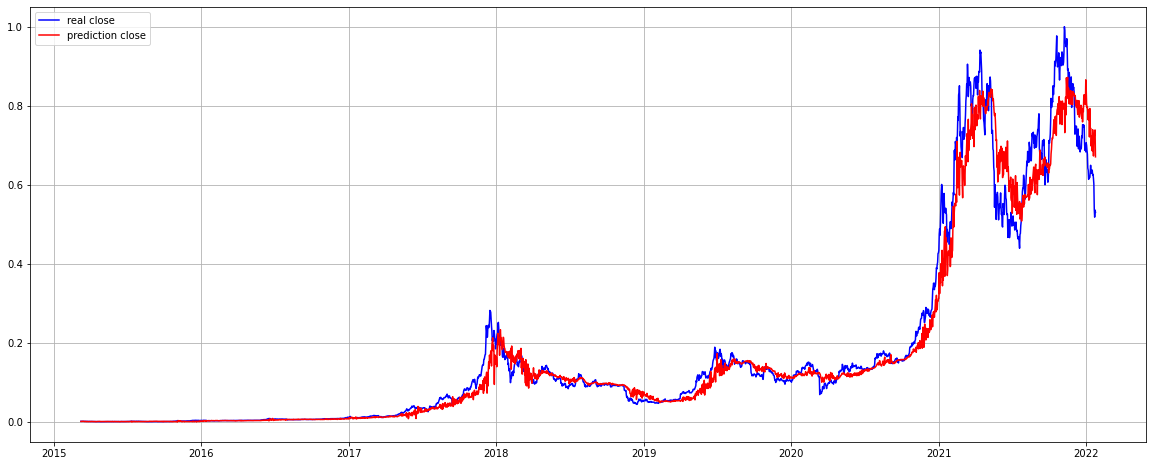

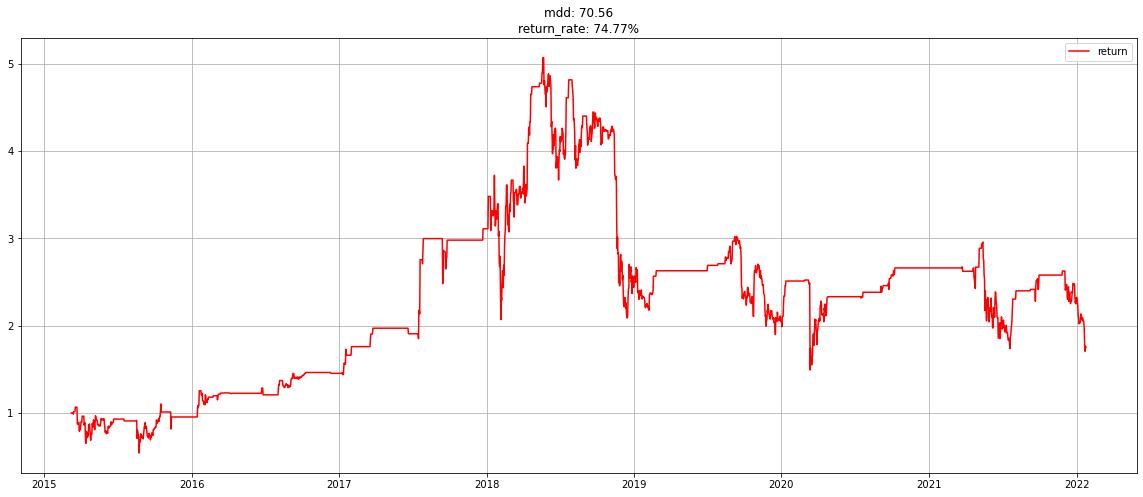

In [6]:
result_df = backtest_lstm_1d(df,100, 1)

In [7]:
analysis_return(result_df)

{'trade_rate': ' 37.07%',
 'success_rate': ' 52.25%',
 'pnl_rate': ' 1.12',
 'mdd': ' 70.56%',
 'cr': ' 74.77%'}

In [8]:
result_df

,o,h,l,c,v,prediction_close,batch_open,trade,ror,cr,mdd
2015-03-09,0.001675,0.001107,0.001842,0.001855,0.004389,0.001562,0.001675,0,1,1,0.0
2015-03-10,0.001855,0.001221,0.00199,0.001903,0.004848,0.001473,0.001855,0,1,1,0.0
2015-03-11,0.001903,0.00122,0.002019,0.001975,0.002563,0.001499,0.001903,0,1,1,0.0
2015-03-12,0.001975,0.001237,0.002067,0.001982,0.003107,0.001943,0.001975,0,1,1,0.0
2015-03-13,0.001982,0.001207,0.001976,0.001816,0.003437,0.001646,0.001982,0,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-20,0.616916,0.629563,0.611244,0.602016,0.000003,0.715576,0.616916,1,0.975847,1.975949,61.009136
2022-01-21,0.600912,0.594628,0.533614,0.539096,0.000008,0.722315,0.600912,1,0.897131,1.772684,65.020106
2022-01-22,0.538475,0.532267,0.512085,0.518259,0.000006,0.731368,0.538475,1,0.962458,1.706134,66.333321
2022-01-23,0.518254,0.528611,0.521535,0.536101,0.000003,0.73887,0.518254,1,1.034438,1.764889,65.173919


In [9]:
from sklearn.metrics import mean_squared_error
y=result_df['c']
y_pred=result_df['prediction_close']
RMSE = mean_squared_error(y, y_pred)**0.5
print(RMSE)

0.045960248353964825


# 문제점 (5월 5일 19:44 기준)
###
### MinMax Scaling으로 데이터셋을 전처리한 후 모든 내용을 일괄 수행하다 보니, 
### 수익률 측정도 MinMax Scaling 처리된 값을 기준으로 진행되어, 실제 값과 다를 수 있음
### 학습 속도 너무 오래 걸렸음;; 